# Chapter 4 Fused Lasso

In [2]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats

C:\Users\prof-\anaconda3\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## 4.1 Applications of Fused Lasso

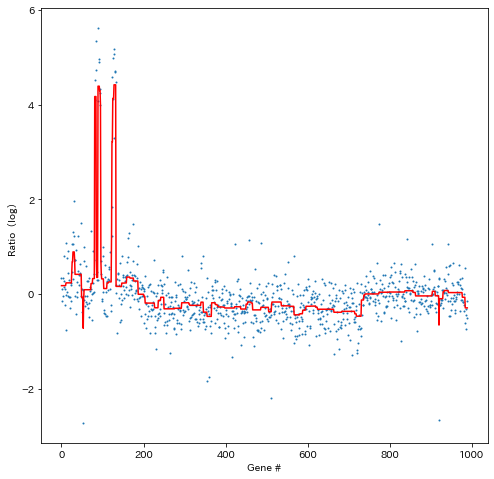

In [42]:
# Use fused which will be defined in this chapter
df = np.loadtxt("cgh.txt", delimiter="\t")
y = df
n = len(y)
lam = 1
soln = fused(y, lam)
plt.xlabel("Gene #")
plt.ylabel("Ratio（log）")
plt.scatter(np.arange(n), y, s=1)
plt.plot(soln, color="red")

In [4]:
from japanmap import pref_names, pref_code, picture
from pylab import rcParams

In [5]:
# We may change the color by changing this function
def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value - minimum) / (maximum - minimum)
    r = 255
    g = int(max(0, 255 * (ratio / 2)))
    b = 0
    return r, g, b

In [44]:
# Use the function admm that will be defined in this chapter
lam = 50
mat = np.loadtxt("adj.txt", delimiter=" ")
y = np.loadtxt("2020_6_9.txt", delimiter=" ")
u = []; v = []
for i in range(46):
    for j in range(i+1, 47):
        if mat[i, j] == 1:
            u.append(i); v.append(j)
m = len(u)
D = np.zeros((m, 47))
for k in range(m):
    D[k, u[k]] = 1; D[k, v[k]] = -1
z = admm(y, D, lam)
cc = np.round((10 - np.log(z)) * 2 - 1)
min_cc = np.min(cc); max_cc = np.max(cc)
data = {}
for i in range(47):
    data[i+1] = rgb(min_cc, max_cc, cc[i])

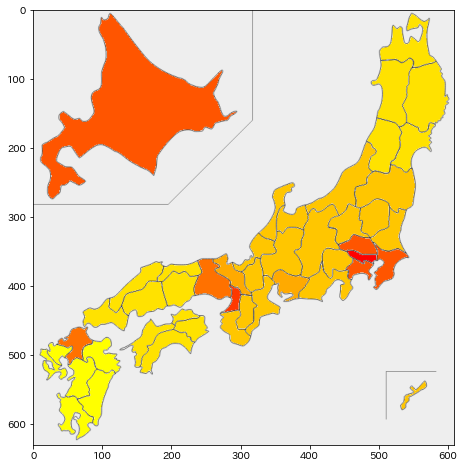

In [45]:
rcParams["figure.figsize"] = 8, 8
plt.imshow(picture())
plt.imshow(picture(data))

In [46]:
n = 50
x = np.array(range(n))
y = np.sign(x / n * 2 * np.pi) + randn(n)
lam = 1

In [47]:
def k_order(n, k):
    D = np.zeros((n-1, n))
    for i in range(n-1):
        D[i, i] = 1
        D[i, i+1] = -1
    for j in range(1, k):
        DD = np.zeros((n-j-1, n-j))
        for i in range(n-j-2):
            DD[i, i] = 1
            DD[i, i+1] = -1
        D = np.dot(DD, D)
    return D

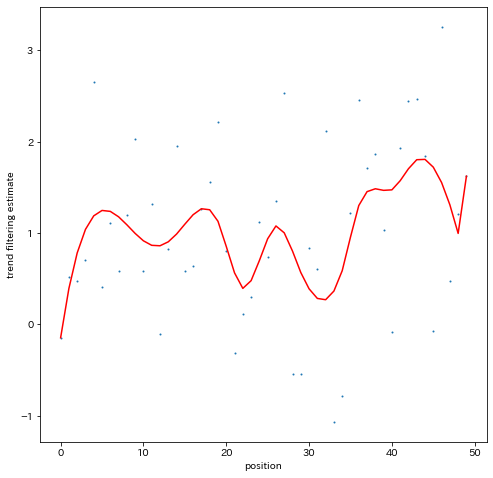

In [48]:
# Use the function admm that will be defined in this chapter
k = 4
D = k_order(n, k)
soln = admm(y, D, lam)
plt.xlabel("position")
plt.ylabel("trend filtering estimate")
plt.scatter(np.arange(n), y, s=1)
plt.plot(soln, color="red")

## 4.2 Solving Fused Lasso via Dynamic Programming 

In [49]:
def clean(z):
    m = len(z)
    j = 1
    while (z[0] >= z[j] and j < m-1):
        j = j + 1
    k = m - 2
    while (z[m-1] <= z[k] and k > 0):
        k = k - 1
    if j > k:
        return z[[0, m-1]]
    else:
        z_append = np.append(z[j:(k+1)], z[m-1])
        return np.append(z[0], z_append)

In [50]:
def G(i, theta, L, U, lam):
    if i == 0:
        return theta - y[0]
    elif (theta > L[i-1] and theta < U[i-1]):
        return G(i-1, theta, L, U, lam) + theta - y[i]
    elif theta >= U[i-1]:
        return lam + theta - y[i]
    else:
        return -lam + theta - y[i]

In [51]:
def fused(y, lam):
    if lam == 0:
        return y
    n = len(y)
    L = np.zeros(n-1)
    U = np.zeros(n-1)
    theta = np.zeros(n)
    L[0] = y[0] - lam
    U[0] = y[0] + lam
    z = [L[0], U[0]]
    if n > 2:
        for i in range(1, n-1):
            z = np.append(y[i] - 2*lam, z)
            z = np.append(z, y[i] + 2*lam)
            z = clean(z)
            m = len(z)
            j = 0
            while G(i, z[j], L, U, lam) + lam <= 0:
                j = j + 1
            if j == 0:
                L[i] = z[m-1]
                j = 1
            else:
                L[i] = z[j-1] - ((z[j] - z[j-1]) * (G(i, z[j-1], L, U, lam) + lam)
                                 / (-G(i, z[j-1], L, U, lam) + G(i, z[j], L, U, lam)))
            k = m - 1
            while G(i, z[k], L, U, lam) - lam >= 0:
                k = k - 1
            if k == m - 1:
                U[i] = z[0]
                k = m - 2
            else:
                U[i] = z[k] - ((z[k+1] - z[k]) * (G(i, z[k], L, U, lam) - lam)
                               / (-G(i, z[k], L, U, lam) + G(i, z[k+1], L, U, lam)))
            z = z[j:(k+1)]
            z = np.append(L[i], z)
            z = np.append(z, U[i])
        z = np.append(y[n-1] - lam, z)
        z = np.append(z, y[n-1] + lam)
        z = clean(z)
        m = len(z)
        j = 0
    while (G(n-1, z[j], L, U, lam) <= 0 and j < m-1):
        j = j + 1
    if j == 0:
        theta[n-1] = z[0]
    else:
        theta[n-1] = (z[j-1]
                      - ((z[j] - z[j-1]) * G(n-1, z[j-1], L, U, lam)
                         / (-G(n-1, z[j-1], L, U, lam) + G(n-1, z[j], L, U, lam))))
    for i in range(n-1, 0, -1):
        if theta[i] < L[i-1]:
            theta[i-1] = L[i-1]
        elif theta[i] > U[i-1]:
            theta[i-1] = U[i-1]
        else:
            theta[i-1] = theta[i]
    return theta

In [52]:
lam = 1
n = 10
y = sorted(randn(n))
print(fused(y, lam))

[-0.5486667  -0.5486667  -0.5486667  -0.5486667  -0.41440679 -0.25425405
  0.28344498  0.50331085  0.55101652  0.55101652]


## 4.3 Lars

In [53]:
def lars(X, y):
    n, p = X.shape
    X_bar = np.zeros(p)
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]
    y_bar = np.mean(y)
    y = y - y_bar
    scale = np.zeros(p)
    for j in range(p):
        scale[j] = np.sqrt(np.sum(X[:, j] * X[:, j]) / n)
        X[:, j] = X[:, j] / scale[j]
    beta = np.zeros((p+1, p))
    lambda_seq = np.zeros(p+1)
    for j in range(p):
        lam = np.abs(np.sum(X[:, j] * y))
        if lam > lambda_seq[0]:
            j_max = j
            lambda_seq[0] = lam
    r = copy.copy(y)
    f_s = list(range(p))
    index = [j_max]
    Delta = np.zeros(p)
    for k in range(1, p):
        sub_s = list(set(f_s) - set(index))
        Delta[index] = (np.linalg.inv(X[:, index].T @ X[:, index]) @ X[:, index].T @ r
                        / lambda_seq[k-1])
        u = X[:, sub_s].T @ (r - lambda_seq[k-1] * X @ Delta)
        v = -X[:, sub_s].T @ (X @ Delta)
        t = u / (v+1)
        for i in range(0, p-k):
            if t[i] > lambda_seq[k]:
                lambda_seq[k] = t[i]
                i_max = i
        t = u / (v-1)
        for i in range(0, p-k):
            if t[i] > lambda_seq[k]:
                lambda_seq[k] = t[i]
                i_max = i
        j = sub_s[i_max]
        index.append(j)
        beta[k, :] = beta[k-1, :] + (lambda_seq[k-1] - lambda_seq[k]) * Delta
        r = y - X @ beta[k, :]
    for k in range(p+1):
        for j in range(p):
            beta[k, j] = beta[k, j] / scale[j]
    return([beta, lambda_seq])

In [55]:
df = np.loadtxt("crime.txt", delimiter="\t")
X = df[:, 2:7]
y = df[:, 0]
res = lars(X, y)
beta, lambda_seq = res
p = beta.shape[1]

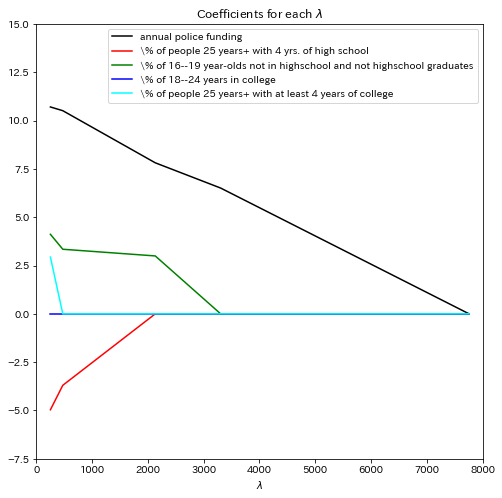

In [58]:
plt.xlim(0, 8000)
plt.ylim(-7.5, 15)
plt.xlabel(r"$\lambda$")
plt.title(r"Coefficients for each $\lambda$")
labels = ["annual police funding", "\% of people 25 years+ with 4 yrs. of high school",
          "\% of 16--19 year-olds not in highschool and not highschool graduates",
          "\% of 18--24 years in college",
          "\% of people 25 years+ with at least 4 years of college"]
cols = ["black", "red", "green", "blue", "cyan"]
for i in range(0, 5):
    plt.plot(lambda_seq[0:p], beta[0:p, i], color=cols[i],label="{}".format(labels[i]))
plt.legend(loc="upper right")

## 4.4 Dual Lasso Problem and Generalized Lasso

In [59]:
def fused_dual(y, D):
    m = D.shape[0]
    lambda_seq = np.zeros(m)
    s = np.zeros(m)
    alpha = np.zeros((m, m))
    alpha[0, :] = np.linalg.pinv(D @ D.T) @ D @ y
    for j in range(m):
        if np.abs(alpha[0, j]) > lambda_seq[0]:
            lambda_seq[0] = np.abs(alpha[0, j])
            index = [j]
            if alpha[0, j] > 0:
                s[j] = 1
            else:
                s[j] = -1
    f_s = list(range(m))
    for k in range(1, m):
        sub_s = list(set(f_s) - set(index))
        U = np.linalg.pinv(D[sub_s, :] @ D[sub_s, :].T)
        V = D[sub_s, :] @ D[index, :].T
        u = U @ D[sub_s, :] @ y
        v = U @ V @ s[index]
        t = u / (v+1)
        for i in range(0, m-k):
            if t[i] > lambda_seq[k]:
                lambda_seq[k] = t[i]
                h = i
                r = 1
        t = u / (v-1)
        for i in range(0, m-k):
            if t[i] > lambda_seq[k]:
                lambda_seq[k] = t[i]
                h = i
                r = -1
        alpha[k, index] = lambda_seq[k] * s[index]
        alpha[k, sub_s] = u - lambda_seq[k] * v
        h = sub_s[h]
        index.append(h)
        if r == 1:
            s[h] = 1
        else:
            s[h] = -1
    return [alpha, lambda_seq]

In [60]:
def fused_prime(y, D):
    alpha, lambda_seq = fused_dual(y, D)
    m = D.shape[0]
    return [np.tile(y, (m, 1)).T - D.T @ alpha.T, lambda_seq]

In [61]:
p = 8
m = p - 1
D = (np.eye(p) + np.diag([-1]*(p-1), k=1))[:-1]
y = sorted(randn(p))

In [62]:
alpha, lambda_seq = fused_dual(y, D)
lambda_max = np.max(lambda_seq)
alpha_min = np.min(alpha)
alpha_max = np.max(alpha)

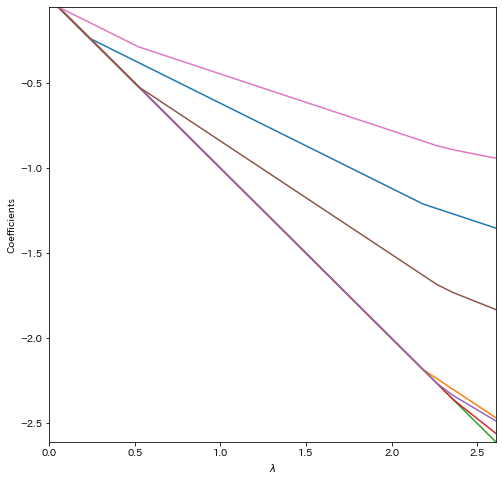

In [63]:
plt.xlim(0, lambda_max)
plt.ylim(alpha_min, alpha_max)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
for i in range(0, m):
    plt.plot(lambda_seq, alpha[:, i])

In [64]:
beta, lambda_seq = fused_prime(y, D)
beta_min = np.min(beta)
beta_max = np.max(beta)

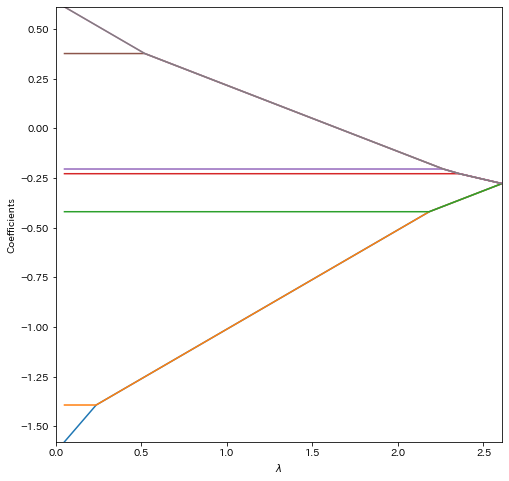

In [65]:
plt.xlim(0, lambda_max)
plt.ylim(beta_min, beta_max)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
for i in range(0, p):
    plt.plot(lambda_seq, beta[i, :])

In [66]:
def fused_dual_general(X, y, D):
    X_plus = np.linalg.inv(X.T @ X) @ X.T
    D_tilde = D @ X_plus
    y_tilde = X @ X_plus @ y
    return fused_dual(y_tilde, D_tilde)

In [27]:
def fused_prime_general(X, y, D):
    p = X.shape[1]
    m = D.shape[0]
    X_plus = np.linalg.inv(X.T @ X) @ X.T
    D_tilde = D @ X_plus
    y_tilde = X @ X_plus @ y
    alpha, lambda_seq = fused_dual(y_tilde, D_tilde)
    beta = np.zeros((m, p))
    for k in range(m):
        beta[k, :] = X_plus @ (y.T - D_tilde.T @ alpha[k, :])
    return [beta, lambda_seq]

In [67]:
n = 20
p = 10
beta = randn(p+1)
X = randn(n*p).reshape((n, p))
X_0 = np.insert(X, 0, np.ones(n), axis=1)
y = X_0 @ beta + randn(n)
m = p - 1
D = (np.eye(p) + np.diag([-1]*(p-1), k=1))[:-1]
alpha, lambda_seq = fused_dual_general(X, y, D)

In [68]:
lambda_max = np.max(lambda_seq)
alpha_min = np.min(alpha)
alpha_max = np.max(alpha)

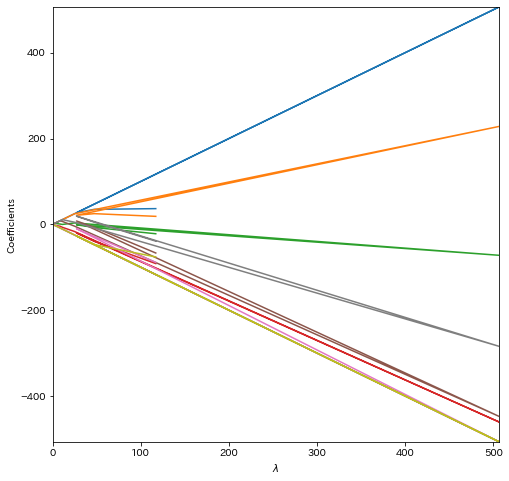

In [69]:
plt.xlim(0, lambda_max)
plt.ylim(alpha_min, alpha_max)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
for i in range(0, m):
    plt.plot(lambda_seq, alpha[:, i])

In [70]:
beta, lambda_seq = fused_prime_general(X, y, D)
beta_min = np.min(beta)
beta_max = np.max(beta)

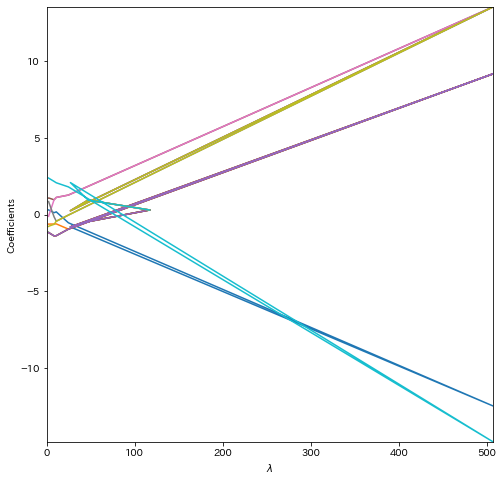

In [71]:
plt.xlim(0, lambda_max)
plt.ylim(beta_min, beta_max)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
for i in range(0, p):
    plt.plot(lambda_seq, beta[:, i])

## 4.5 ADMM

In [72]:
def soft_th(lam, x):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0)
def admm(y, D, lam):
    L, K = D.shape
    theta_old = np.zeros(K)
    theta = np.zeros(K)
    gamma = np.zeros(L)
    mu = np.zeros(L)
    rho = 1
    eps = 1
    while eps > 0.001:
        theta = (np.linalg.inv(np.eye(K) + rho * D.T @ D)
                 @ (y + D.T @ (rho * gamma - mu)))
        gamma = soft_th(lam, rho * D @ theta + mu) / rho
        mu = mu + rho * (D @ theta - gamma)
        eps = np.max(np.abs(theta - theta_old))
        theta_old = copy.copy(theta)
    return theta

In [73]:
df = np.loadtxt("cgh.txt", delimiter="\t")
y = df[100:110]
N = len(y)
D = (np.eye(N) + np.diag([-1]*(N-1), k=1))[:-1]
lambda_seq = np.arange(0, 0.5, 0.01)
M = len(lambda_seq)
theta = np.zeros((10, M))
for k in range(M):
    theta[:, k] = admm(y, D, lambda_seq[k])

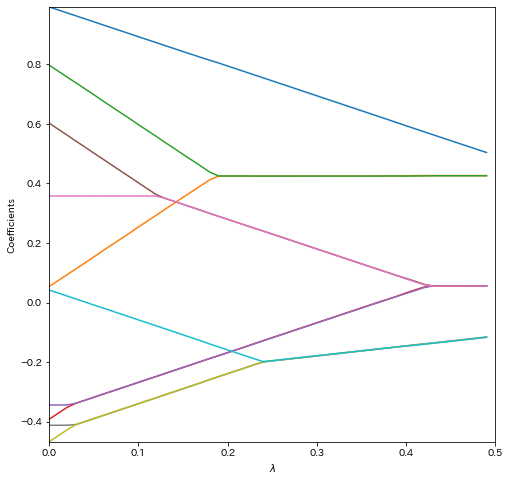

In [74]:
plt.xlim(0, 0.5)
plt.ylim(np.min(theta), np.max(theta))
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
for i in range(0, 10):
    plt.plot(lambda_seq, theta[i, :])